In [1]:
import pandas as pd
import scanpy as sc
import decoupler as dc
import squidpy as sq
import sys
import os
import liana as li
from mudata import MuData

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'aggregate_fun' is not a valid key!


In [2]:
from _estimate_metalinks import estimate_metalinks

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
# Load and preprocess Visium HNE data
adata = sq.datasets.visium_hne_adata()
sc.pp.filter_genes(adata, min_counts=20)
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)


/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning


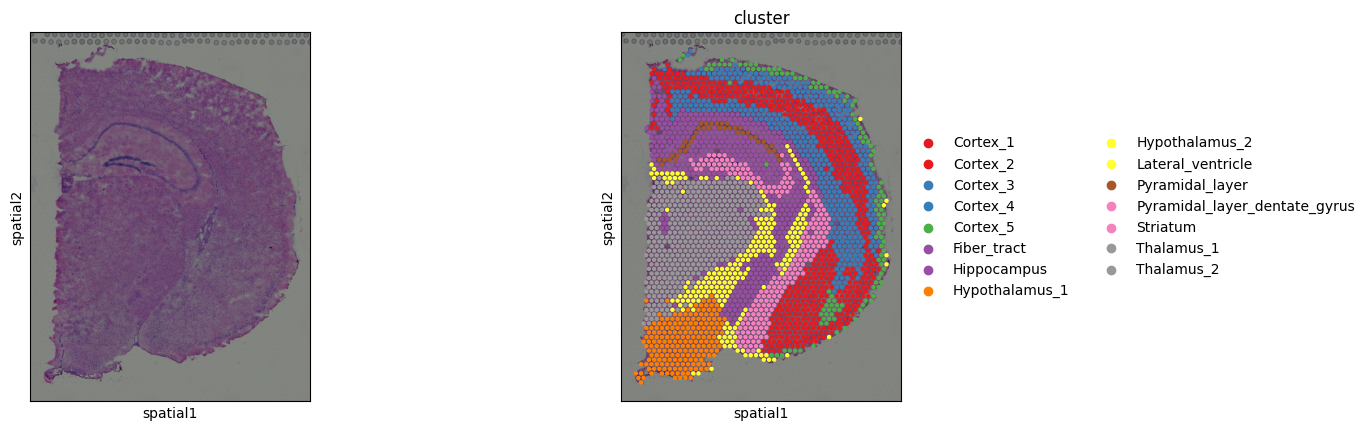

In [4]:
sc.pl.spatial(adata, color=[None, 'cluster'], size=1.3, palette='Set1')

In [5]:
li.ut.spatial_neighbors(adata, bandwidth=150, cutoff=0.1, kernel='gaussian', set_diag=True)

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


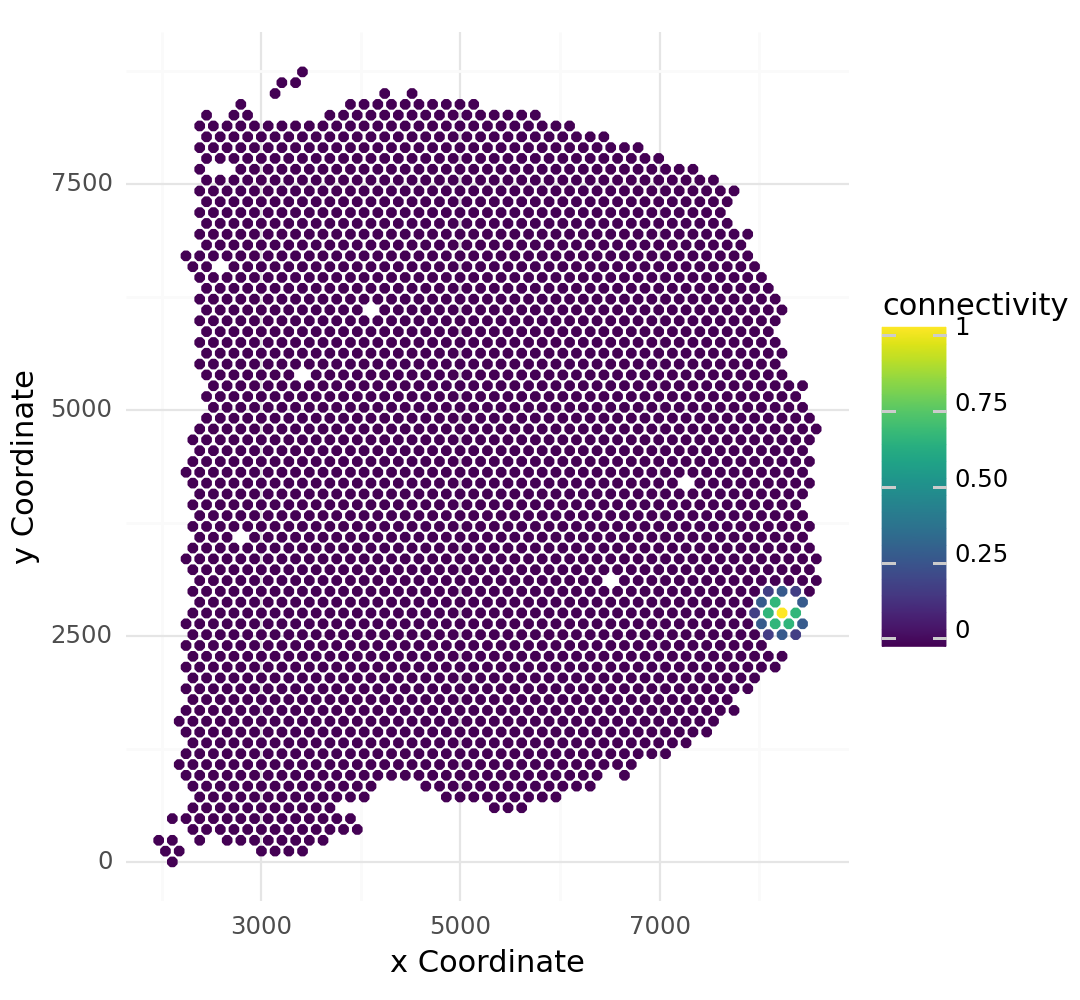

<Figure Size: (540 x 500)>

In [6]:
li.pl.connectivity(adata, idx=0, size=1.3)

In [7]:
# Load metabolite receptor interactions
resource =  pd.read_csv('data/MR_brain_20230808.csv')
# resource = dc.translate_net(resource, columns=['receptor'])
resource['receptor'] = resource['receptor'].str.title()
resource.head()

Unnamed: 0       ligand receptor
0           1  HMDB0000112   Gabrb2
1           3  HMDB0000216   Adra2B
2           4  HMDB0000068   Adra2B
3          20  HMDB0000148     Grm8
4          49  HMDB0000112   Gabra5

In [8]:
met_net = pd.read_csv("data/PD_processed.csv")

In [9]:
# met_net = dc.translate_net(met_net, columns=['Symbol'])
met_net['Symbol'] = met_net['Symbol'].str.title()
met_net.head()

Unnamed: 0         HMDB   Symbol  Direction                      MetName  \
0       18524  HMDB0059655    Phgdh          1           2-Hydroxyglutarate   
1       21107  HMDB0006242  Aldh3A1         -1  3,4-Dihydroxymandelaldehyde   
2       21117  HMDB0000042  Aldh3A1          1                  Acetic acid   
3       21116  HMDB0001487  Aldh3A1          1                         NADH   
4       21115  HMDB0000663  Aldh3A1          1                Glucaric acid   

  Transport T_direction Reversibility                          DB     Type  
0   unknown     unknown  irreversible  ReconProductionDegradation  met_est  
1   unknown     unknown  irreversible  ReconProductionDegradation  met_est  
2   unknown     unknown  irreversible  ReconProductionDegradation  met_est  
3   unknown     unknown  irreversible  ReconProductionDegradation  met_est  
4   unknown     unknown  irreversible  ReconProductionDegradation  met_est

In [10]:
# estimate metabolites
mdata = estimate_metalinks(adata, resource=resource, met_net=met_net, consider_transport=True, min_n=3)

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


In [11]:
mdata.mod['metabolite'].X[mdata.mod['metabolite'].X <= 0] = 0

In [12]:
resource[['x', 'y']] = resource[['ligand', 'receptor']] 

In [13]:
li.mt.bivar(mdata,
            x_mod="metabolite",
            y_mod="rna",
            x_transform=li.ut.zi_minmax,
            y_transform=li.ut.zi_minmax,
            function_name="morans",
            resource=resource,
            mask_negatives=True,
            add_categories=True,
            # y_name="receptor",
            # x_name="ligand",
            xy_sep="&",
            x_use_raw=False,
            y_use_raw=False,
            verbose=True
            )

Using `.X`!
Converting to sparse csr matrix!


Using provided `resource`.
Transforming metabolite using zi_minmax


Using `.X`!
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/merge.py:217: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/merge.py:1111: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
Using `.X`!
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/a

Transforming rna using zi_minmax


In [14]:
mdata.uns['global_res'].sort_values("global_r", ascending=False).head(20)

Unnamed: 0         interaction       ligand receptor            x  \
31         142    HMDB0000259&Htr4  HMDB0000259     Htr4  HMDB0000259   
45        2941    HMDB0000073&Htr6  HMDB0000073     Htr6  HMDB0000073   
32         143    HMDB0000073&Htr4  HMDB0000073     Htr4  HMDB0000073   
44        2940    HMDB0000259&Htr6  HMDB0000259     Htr6  HMDB0000259   
42        2431    HMDB0000073&Drd5  HMDB0000073     Drd5  HMDB0000073   
43        2433    HMDB0000068&Drd5  HMDB0000068     Drd5  HMDB0000068   
41        2430    HMDB0000259&Drd5  HMDB0000259     Drd5  HMDB0000259   
49         321   HMDB0000123&Glra1  HMDB0000123    Glra1  HMDB0000123   
21        1322   HMDB0000148&Gria2  HMDB0000148    Gria2  HMDB0000148   
27        2866   HMDB0000148&Grik3  HMDB0000148    Grik3  HMDB0000148   
7         1967  HMDB0000112&Gabra1  HMDB0000112   Gabra1  HMDB0000112   
30          70   HMDB0001085&Gpr17  HMDB0001085    Gpr17  HMDB0001085   
53         361   HMDB0000068&Adrb2  HMDB0000068    Adrb2  HMDB0000068   
16         785    HMDB0000148&Grm7  HMDB0000148     Grm7  HMDB0000148   
54         362   HMDB0000216&Adrb2  HMDB0000216    Adrb2  HMDB0000216   
8         2557  HMDB0000112&Gabra2  HMDB0000112   Gabra2  HMDB0000112   
13          20    HMDB0000148&Grm8  HMDB0000148     Grm8  HMDB0000148   
20        1199   HMDB0000148&Grik4  HMDB0000148    Grik4  HMDB0000148   
14          74    HMDB0000148&Grm2  HMDB0000148     Grm2  HMDB0000148   
17         889   HMDB0000148&Grik5  HMDB0000148    Grik5  HMDB0000148   

     x_means   x_props       y   y_means   y_props  global_r global_pvals  
31  0.328128  0.992560    Htr4  0.016702  0.032366  0.040248         None  
45  0.332915  0.990699    Htr6  0.013429  0.031250  0.038441         None  
32  0.332915  0.990699    Htr4  0.016702  0.032366  0.035565         None  
44  0.328128  0.992560    Htr6  0.013429  0.031250  0.029541         None  
42  0.332915  0.990699    Drd5  0.026999  0.067708  0.027468         None  
43  0.128376  0.802827    Drd5  0.026999  0.067708  0.024532         None  
41  0.328128  0.992560    Drd5  0.026999  0.067708  0.024493         None  
49  0.033673  0.382068   Glra1  0.013910  0.024926  0.024075         None  
21  0.001120  0.006696   Gria2  0.609827  0.935640  0.016030         None  
27  0.001120  0.006696   Grik3  0.161619  0.338542  0.015638         None  
7   0.027875  0.946801  Gabra1  0.582197  0.936012  0.014819         None  
30  0.005248  0.058036   Gpr17  0.130266  0.316220  0.014802         None  
53  0.128376  0.802827   Adrb2  0.014269  0.040923  0.013499         None  
16  0.001120  0.006696    Grm7  0.187141  0.417783  0.013201         None  
54  0.139352  0.811756   Adrb2  0.014269  0.040923  0.011646         None  
8   0.027875  0.946801  Gabra2  0.424055  0.780134  0.010903         None  
13  0.001120  0.006696    Grm8  0.067652  0.173735  0.010571         None  
20  0.001120  0.006696   Grik4  0.144934  0.286086  0.010279         None  
14  0.001120  0.006696    Grm2  0.174777  0.355655  0.008843         None  
17  0.001120  0.006696   Grik5  0.504090  0.895461  0.008651         None

In [15]:
li.mt.bivar(mdata,
            x_mod="metabolite",
            y_mod="rna",
            x_transform=li.ut.zi_minmax,
            y_transform=li.ut.zi_minmax,
            function_name="cosine",
            resource=resource,
            mask_negatives=True,
            add_categories=True,
            xy_sep="&",
            x_use_raw=False,
            y_use_raw=False,
            n_perms=100, 
            verbose=True
            )

Using `.X`!
Converting to sparse csr matrix!


Using provided `resource`.
Transforming metabolite using zi_minmax


Using `.X`!
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/merge.py:217: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/merge.py:1111: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
Using `.X`!
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/a

Transforming rna using zi_minmax


100%|██████████| 100/100 [00:08<00:00, 11.81it/s]


In [16]:
interaction = 'HMDB0000112&Gabra2'

Generate the Plot for the Manuscript

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:649: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:471: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:649: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/dbdimitrov/anaconda3/envs/spia

(0.0, 1.0, 0.0, 1.0)

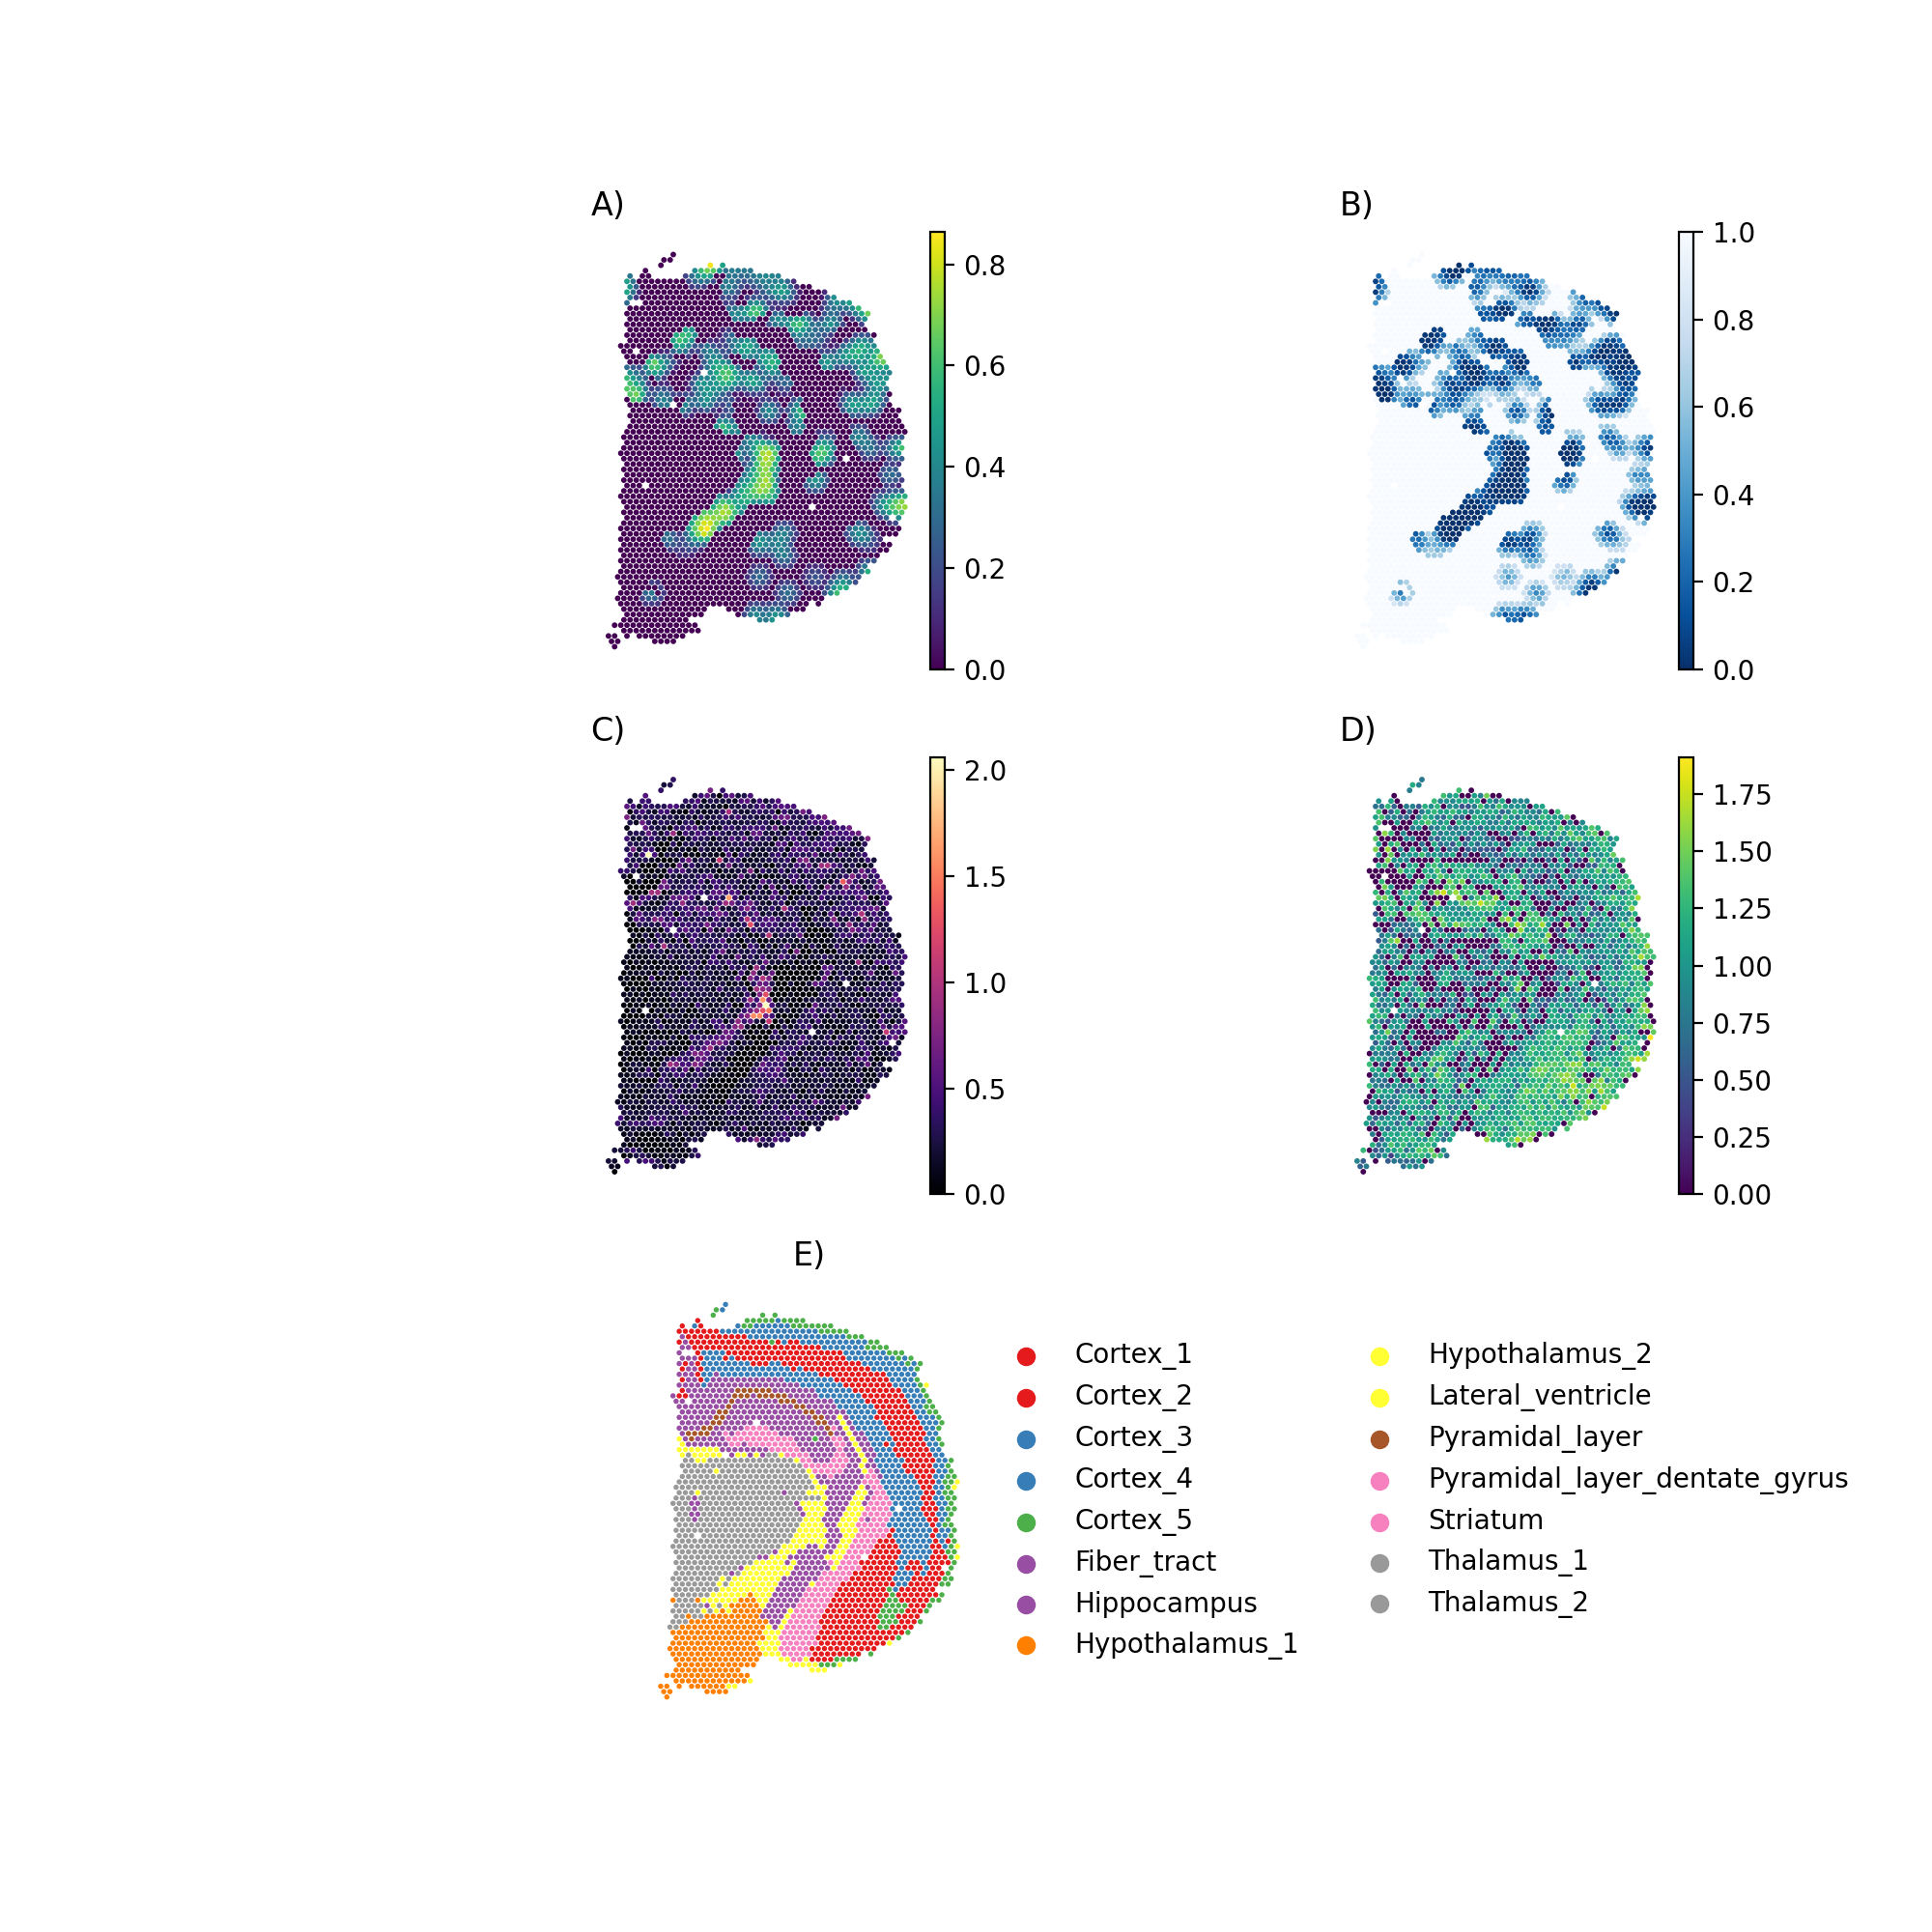

In [17]:
import matplotlib.pyplot as plt

# four ax for four plots, with some space between them
fig, axs = plt.subplots(3, 2, figsize=(10, 10), gridspec_kw={'wspace': 0, 'hspace': 0.2})

sq.pl.spatial_scatter(mdata.mod['local_scores'], color=interaction, size=1.4, palette='Paired', ax=axs[0, 0], img=False, frameon=False, title='') # , vmax=0.15, vmin=-0.15
axs[0, 0].set_title('A)', loc='left')

sq.pl.spatial_scatter(mdata.mod['local_scores'], color=interaction, size=1.4, palette='Paired', ax=axs[0, 1], img=False, frameon=False, layer='pvals', cmap='Blues_r', title='') # , vmax=0.15, vmin=-0.15
axs[0, 1].set_title('B)', loc='left')

sq.pl.spatial_scatter(mdata.mod['metabolite'], color=['HMDB0000112'], size=1.4, palette='Paired', ax=axs[1, 0], img=False, frameon=False, title='', cmap='magma')
axs[1, 0].set_title('C)', loc='left')

sq.pl.spatial_scatter(mdata.mod['rna'], color=['Gabra2'], size=1.4, palette='Paired', ax=axs[1, 1], img=False, frameon=False, use_raw=False, title='')
axs[1, 1].set_title('D)', loc='left')

# plot the first ax
sq.pl.spatial_scatter(adata, color=['cluster'], size=1.3, palette='Set1', ax=axs[2, 0], frameon=False, img=False)
# move slightly to the right
axs[2, 0].set_position([axs[2, 0].get_position().x0 + 0.1, axs[2, 0].get_position().y0, axs[2, 0].get_position().width, axs[2, 0].get_position().height])

axs[2, 0].set_title('E)')

axs[2, 1].axis('off')


Explore

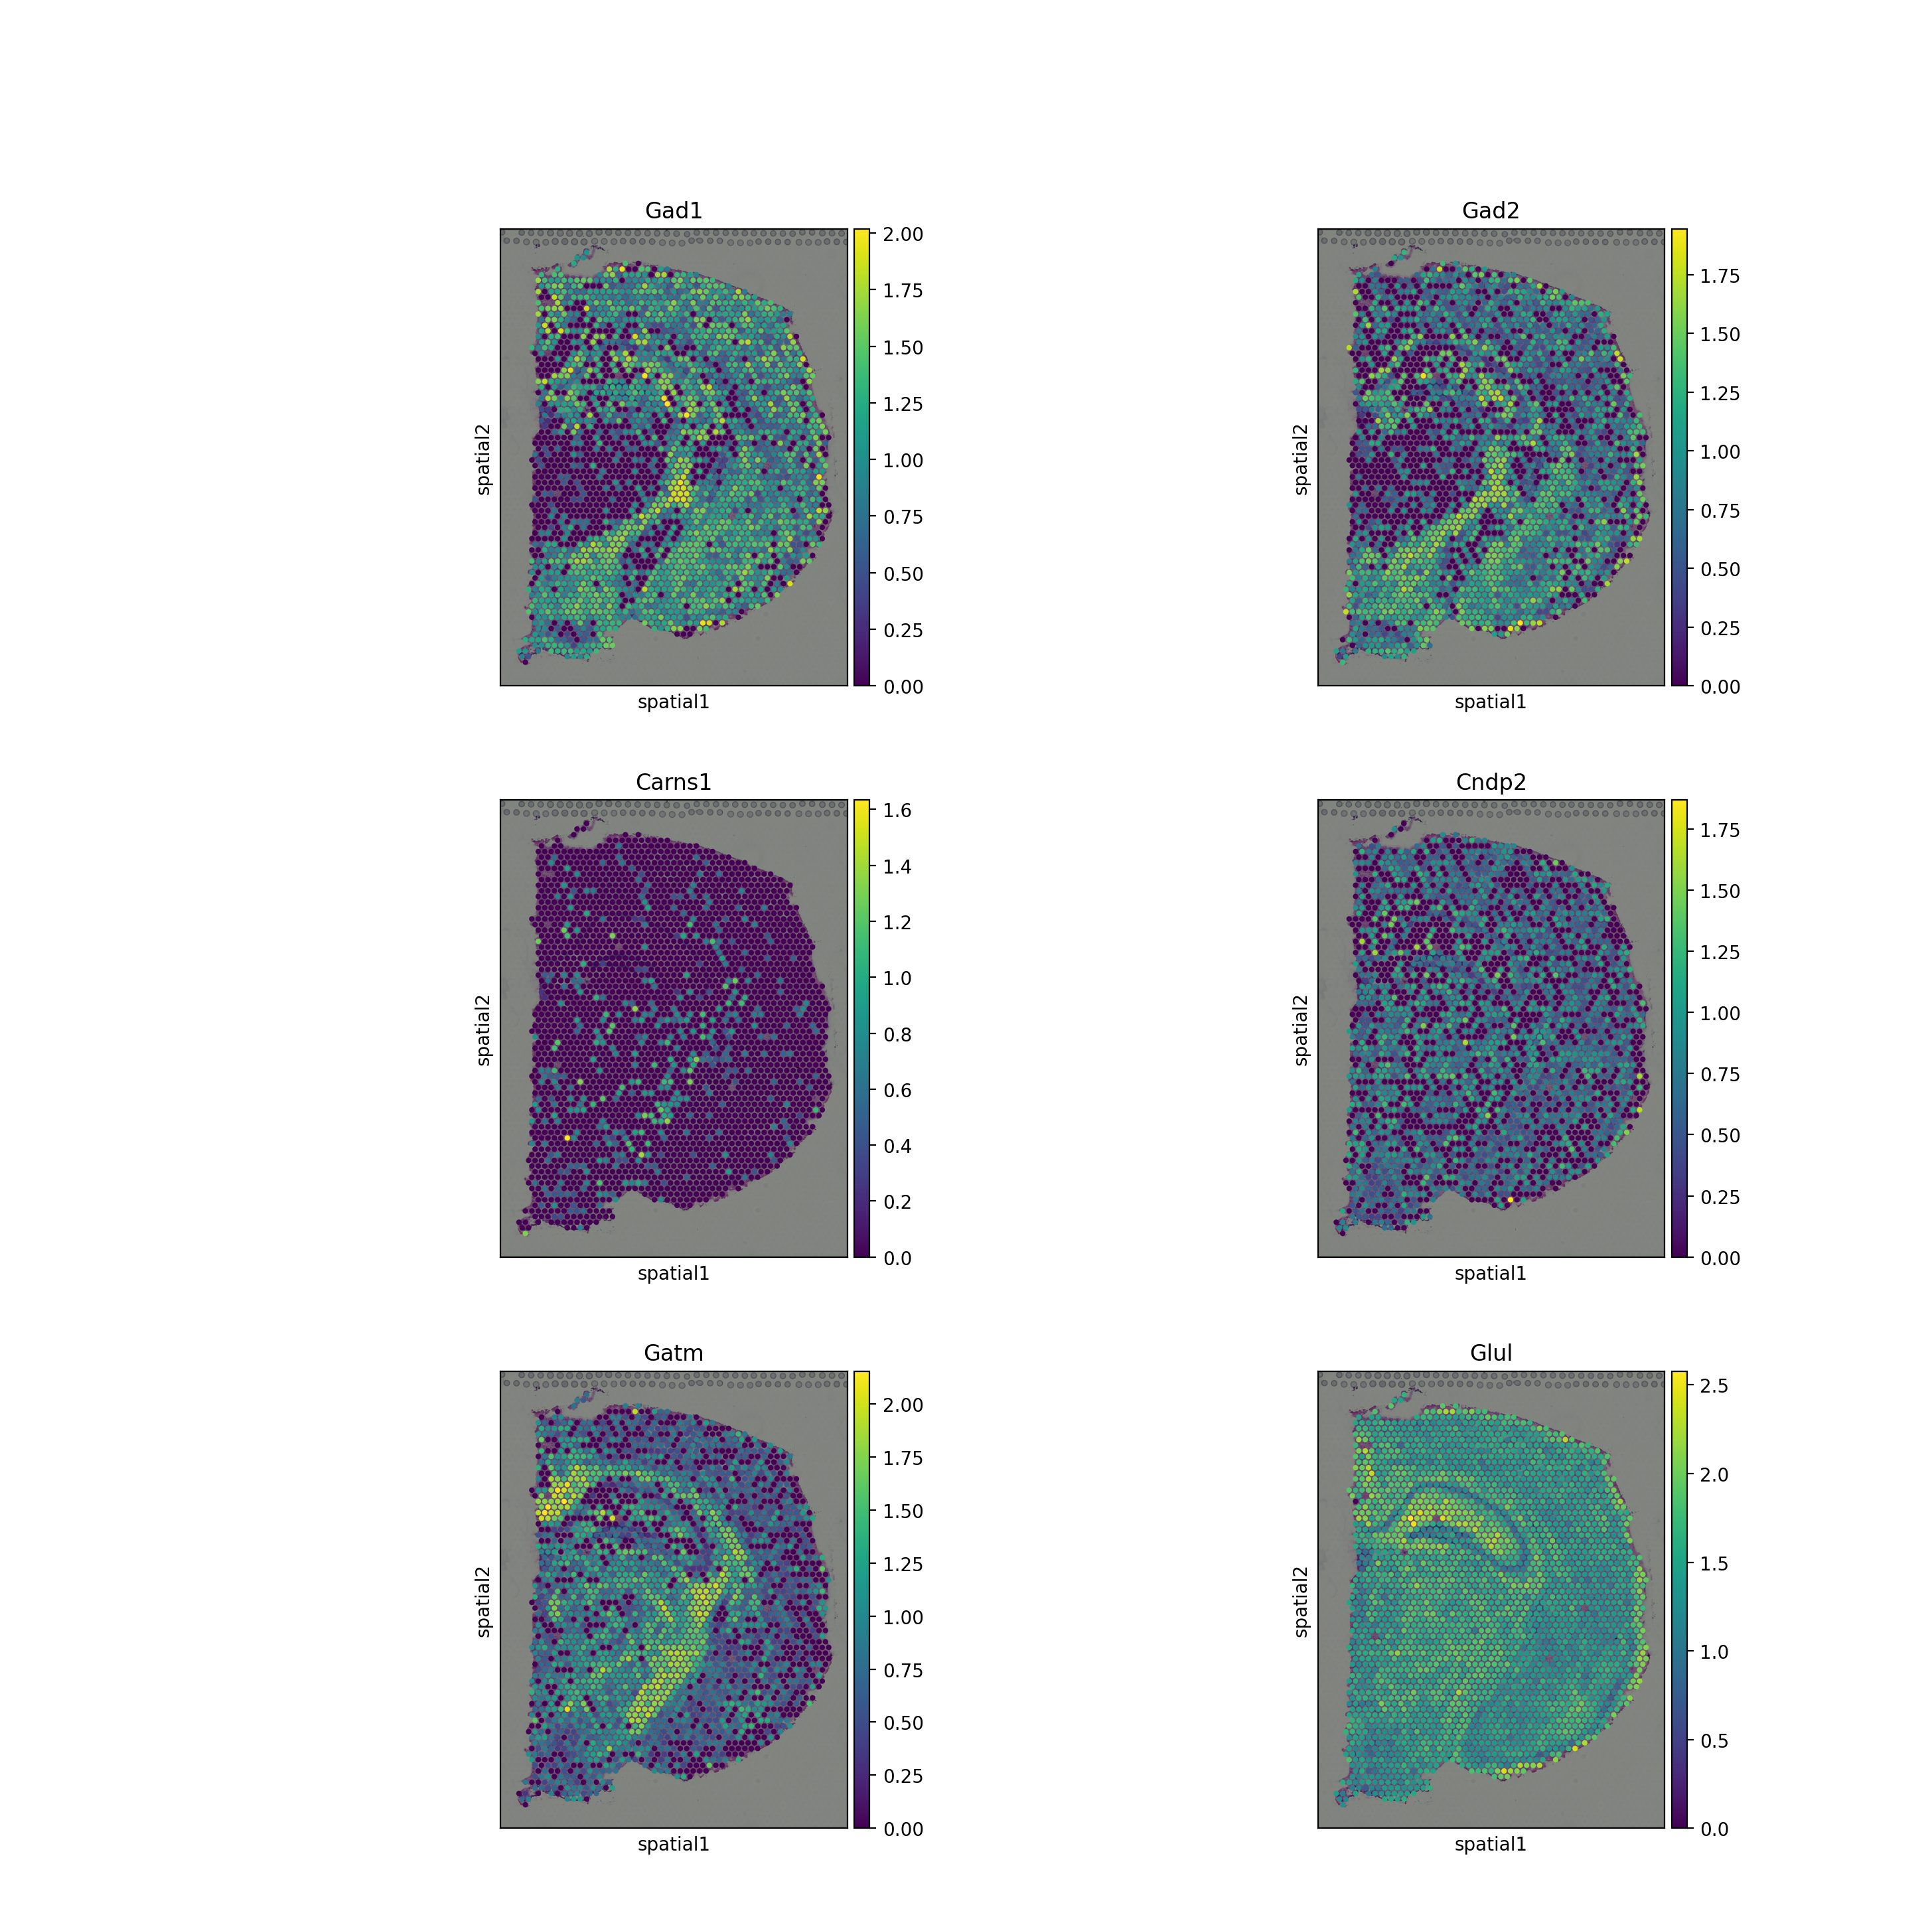

In [18]:
# plot all the genes that play a role in retinoic acid set
met_sets = met_net[met_net['Type']=='met_est']
genes = met_sets[met_sets['HMDB'] == 'HMDB0000112']['Symbol']
#remove Cyp4a11
#lower case except first letter
genes = [gene[0].upper() + gene[1:].lower() for gene in genes]
# remove genes that are not in adata.var.index
genes = [gene for gene in genes if gene in adata.var.index]
sc.pl.spatial(adata, color=genes, size=1.3, palette='Paired', use_raw=False, ncols=2)

In [19]:
met_sets[met_sets['HMDB'] == 'HMDB0000112']

Unnamed: 0         HMDB  Symbol  Direction                  MetName  \
757         20423  HMDB0000112    Gad1          1  gamma-Aminobutyric acid   
5548        39470  HMDB0000112    Gad2          1  gamma-Aminobutyric acid   
6455        31030  HMDB0000112  Carns1         -1  gamma-Aminobutyric acid   
11838        6576  HMDB0000112   Cndp2          1  gamma-Aminobutyric acid   
11963       22601  HMDB0000112   Cndp1          1  gamma-Aminobutyric acid   
13017       12299  HMDB0000112    Gatm         -1  gamma-Aminobutyric acid   
14994       28052  HMDB0000112    Glul          1  gamma-Aminobutyric acid   

      Transport T_direction Reversibility                          DB     Type  
757     unknown     unknown  irreversible  ReconProductionDegradation  met_est  
5548    unknown     unknown  irreversible  ReconProductionDegradation  met_est  
6455    unknown     unknown  irreversible  ReconProductionDegradation  met_est  
11838   unknown     unknown  irreversible    HmrProductionDegradation  met_est  
11963   unknown     unknown  irreversible    HmrProductionDegradation  met_est  
13017       NaN     unknown           NaN   HmdbProductionDegradation  met_est  
14994       NaN     unknown           NaN   HmdbProductionDegradation  met_est